# TFM modelo forcast Bitcoin.
### Script por Ignacio Dorado Bermúdez de Castro

## <font color="#CA3532"> **1. Importación de librerías**

In [1]:
import fredapi as fa
import pandas as pd
import datetime as dt
import matplotlib as plt
import ccxt
import datetime as dt
import seaborn as sns
import os
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1, L2, L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [2]:
folder_path = 'dff'
df = pd.read_csv('dff/bitcoin-price-usd.csv')
df = df.rename(columns = {'timestamp': 'Date'})
df.Date = pd.to_datetime(df.Date, dayfirst = True)
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df_aux= pd.read_csv(file_path)
        df_aux = df_aux.reset_index()
        df_aux = df_aux.rename(columns = {'timestamp': 'Date', 'value': filename})
        df_aux.Date = pd.to_datetime(df_aux.Date, dayfirst = True)
        df_aux = df_aux.drop(columns=( 'index'))
        df = pd.merge(df,df_aux, how='outer', on= 'Date')

In [ ]:
from fredapi import Fred 
fred = Fred(api_key='2b4f45f686b657db324175063ddfc00e')
interest_table = fred.get_series('DFF', observation_start='2009-3-1')
interest_table = pd.DataFrame(interest_table, columns = ['interest'])
interest_table = interest_table.reset_index()
interest_table = interest_table.rename(columns = {'index': 'Date', '0':'Interest'})
interest_table['Date'] = pd.to_datetime(interest_table['Date'], utc = True)

## <font color="#CA3532"> **3. Preprocesado inicial y filtrado de datos**

In [ ]:
df = pd.merge(interest_table, df, how='outer', on= 'Date')
df

,Date,interest,value,price_x,score,bitcoin-adjusted-sopr-a-sopr.csv,bitcoin-aggregate-security-spend-thermocap-usd.csv,1m,1w,1y,...,bitcoin-reserve-risk.csv,bitcoin-stock-to-flow-deflection.csv,daysTillHalving,price_y,ratio,bitcoin-total-miner-revenue-btc-all-miners.csv,bitcoin-total-transaction-fees-btc.csv,bitcoin-total-transfer-volume-from-exchanges-btc-all-exchanges.csv,bitcoin-total-transfer-volume-to-exchanges-btc-all-exchanges.csv,bitcoin-velocity.csv
0,2009-03-01 00:00:00+00:00,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5250.0,0.0,NaN,NaN,NaN
1,2009-03-02 00:00:00+00:00,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5400.0,0.0,NaN,NaN,NaN
2,2009-03-03 00:00:00+00:00,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5250.0,0.0,NaN,NaN,NaN
3,2009-03-04 00:00:00+00:00,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5200.0,0.0,NaN,NaN,NaN
4,2009-03-05 00:00:00+00:00,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5600.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,2028-03-11 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,34.0,NaN,1.404172e+06,NaN,NaN,NaN,NaN,NaN
7008,2028-03-12 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,33.0,NaN,1.404372e+06,NaN,NaN,NaN,NaN,NaN
7009,2028-03-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,32.0,NaN,1.404394e+06,NaN,NaN,NaN,NaN,NaN
7010,2028-03-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,31.0,NaN,1.404505e+06,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.sort_values(by='Date', ascending=True)
df

,Date,interest,value,price_x,score,bitcoin-adjusted-sopr-a-sopr.csv,bitcoin-aggregate-security-spend-thermocap-usd.csv,1m,1w,1y,...,bitcoin-reserve-risk.csv,bitcoin-stock-to-flow-deflection.csv,daysTillHalving,price_y,ratio,bitcoin-total-miner-revenue-btc-all-miners.csv,bitcoin-total-transaction-fees-btc.csv,bitcoin-total-transfer-volume-from-exchanges-btc-all-exchanges.csv,bitcoin-total-transfer-volume-to-exchanges-btc-all-exchanges.csv,bitcoin-velocity.csv
5136,2009-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,50.0,0.0,NaN,NaN,NaN
5137,2009-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
5138,2009-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
5139,2009-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
5140,2009-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,2028-03-11 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,34.0,NaN,1.404172e+06,NaN,NaN,NaN,NaN,NaN
7008,2028-03-12 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,33.0,NaN,1.404372e+06,NaN,NaN,NaN,NaN,NaN
7009,2028-03-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,32.0,NaN,1.404394e+06,NaN,NaN,NaN,NaN,NaN
7010,2028-03-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,31.0,NaN,1.404505e+06,NaN,NaN,NaN,NaN,NaN


In [ ]:
filtered_df = df.loc[(df['Date'] >= '2017-09-01')
                     & (df['Date'] < '2023-03-07')]

In [ ]:
filtered_df = filtered_df.drop(columns=['1m', '1y', 'price_x', 'price_y', '2w', 'daysTillHalving', 'bitcoin-total-miner-revenue-btc-all-miners.csv', 'bitcoin-total-transfer-volume-from-exchanges-btc-all-exchanges.csv', 'bitcoin-total-transfer-volume-to-exchanges-btc-all-exchanges.csv', 'bitcoin-realized-loss-usd.csv', 'bitcoin-realized-profit-usd.csv', 'bitcoin-total-transaction-fees-btc.csv', 'bitcoin-price-usd.csv', 'bitcoin-market-value-to-realized-value-ratio-mvrv.csv', 'bitcoin-percent-miner-revenue-from-fees.csv', 'bitcoin-bitcoin-volatility-index-bvin.csv', 'ratio'])
filtered_df

,Date,interest,value,score,bitcoin-adjusted-sopr-a-sopr.csv,bitcoin-aggregate-security-spend-thermocap-usd.csv,1w,3m,6m,bitcoin-balance-on-exchanges-btc-all-exchanges.csv,...,bitcoin-network-value-to-transactions-ratio-nvt.csv,bitcoin-number-of-active-addresses-7d-exponential-moving-average.csv,bitcoin-number-of-addresses-with-balance-10k-7d-exponential-moving-average.csv,bitcoin-number-of-transfers-to-exchanges-all-exchanges.csv,bitcoin-percent-supply-in-profit.csv,bitcoin-proof-of-reserves-btc-binance.csv,bitcoin-realized-profits-to-value-rpv-ratio.csv,bitcoin-reserve-risk.csv,bitcoin-stock-to-flow-deflection.csv,bitcoin-velocity.csv
3106,2017-09-01 00:00:00+00:00,1.16,4930.913963,0.728379,1.102286,2.935086e+09,42.076305,93.197997,87.383890,1.541996e+06,...,11.882631,782815.0,119.0,67756.0,1.000000,NaN,0.011804,0.009381,0.885068,0.084156
3107,2017-09-02 00:00:00+00:00,1.16,4635.549367,0.663077,1.074140,2.944726e+09,52.419072,93.596394,87.571835,1.545729e+06,...,14.451097,694967.0,119.0,60743.0,0.966686,NaN,0.008197,0.009190,0.822980,0.069199
3108,2017-09-03 00:00:00+00:00,1.16,4624.004129,0.593851,1.054825,2.953608e+09,58.076169,93.552071,87.622716,1.539766e+06,...,15.137668,586948.0,120.0,46411.0,0.966337,NaN,0.005420,0.009028,0.829686,0.066060
3109,2017-09-04 00:00:00+00:00,1.16,4340.747306,0.585409,1.048014,2.963283e+09,68.339057,94.062383,87.921438,1.545603e+06,...,8.889762,752538.0,120.0,76214.0,0.905535,NaN,0.009415,0.008664,0.779758,0.112489
3110,2017-09-05 00:00:00+00:00,1.16,4426.660415,0.582226,1.028321,2.973923e+09,70.493068,94.405252,88.163776,1.536157e+06,...,2.786076,784405.0,120.0,71144.0,0.946973,NaN,0.006662,0.008468,0.794568,0.358928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5114,2023-03-02 00:00:00+00:00,4.57,23479.321887,0.077757,0.992648,4.618465e+10,31.905661,43.474396,50.918287,2.298106e+06,...,54.253393,941558.0,118.0,58541.0,0.702975,370391.427771,0.000188,0.001009,0.211615,0.018432
5115,2023-03-03 00:00:00+00:00,4.57,22359.217210,0.046845,0.983874,4.620821e+10,40.604218,44.536859,51.288534,2.294504e+06,...,44.631996,1087113.0,118.0,65459.0,0.648042,367581.944542,0.000179,0.000965,0.201790,0.022405
5116,2023-03-04 00:00:00+00:00,4.57,22347.343924,0.021576,0.991880,4.622944e+10,37.691393,44.599823,51.307524,2.295096e+06,...,68.896362,904505.0,118.0,49740.0,0.647751,368872.278777,0.000121,0.000961,0.201839,0.014515
5117,2023-03-05 00:00:00+00:00,4.57,22442.474539,0.000000,0.952750,4.625116e+10,36.421549,44.536235,51.306392,2.297271e+06,...,63.043029,992659.0,117.0,46640.0,0.654879,370884.353890,0.000168,0.000964,0.202609,0.015862


In [ ]:
filtered_df.isnull().sum()

Date                                                                                0
interest                                                                            0
value                                                                               0
score                                                                               0
bitcoin-adjusted-sopr-a-sopr.csv                                                    0
bitcoin-aggregate-security-spend-thermocap-usd.csv                                  0
1w                                                                                  0
3m                                                                                  0
6m                                                                                  0
bitcoin-balance-on-exchanges-btc-all-exchanges.csv                                  0
bitcoin-balanced-price-usd.csv                                                      0
bitcoin-exchange-net-position-change-btc-all-exchanges

In [ ]:
columns = ['bitcoin-adjusted-sopr-a-sopr.csv', 'bitcoin-aggregate-security-spend-thermocap-usd.csv', '1w', '3m', '6m', 'bitcoin-balanced-price-usd.csv', 'bitcoin-balance-on-exchanges-btc-all-exchanges.csv', 'bitcoin-exchange-net-position-change-btc-all-exchanges.csv', 'bitcoin-investor-capitalization.csv', 'bitcoin-market-cap-to-thermocap-ratio.csv', 'bitcoin-network-value-to-transactions-ratio-nvt.csv', 'bitcoin-net-realized-profit-loss-usd.csv', 'bitcoin-net-transfer-volume-from-to-exchanges-btc-all-exchanges.csv', 'bitcoin-number-of-active-addresses-7d-exponential-moving-average.csv', 'bitcoin-number-of-addresses-with-balance-10k-7d-exponential-moving-average.csv', 'bitcoin-number-of-transfers-to-exchanges-all-exchanges.csv', 'bitcoin-proof-of-reserves-btc-binance.csv','bitcoin-mean-transaction-fees-btc.csv', 'bitcoin-reserve-risk.csv', 'bitcoin-realized-profits-to-value-rpv-ratio.csv']

## <font color="#CA3532"> **4. Escalado de datos, transformación de la variable a predecir y selección de variables que entraran en el modelo**

In [ ]:
scaled_df=filtered_df

In [ ]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/67597.00657928495
def inverse_transform(x_escalado):
    return x_escalado*67597.00657928495

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaled_df[columns] = minmax_scale(scaled_df[columns])

In [ ]:
scaled_df = scaled_df.reset_index()
scaled_df = scaled_df.drop(columns=['index'])

In [ ]:
scaled_df

,Date,interest,value,score,bitcoin-adjusted-sopr-a-sopr.csv,bitcoin-aggregate-security-spend-thermocap-usd.csv,1w,3m,6m,bitcoin-balance-on-exchanges-btc-all-exchanges.csv,...,bitcoin-network-value-to-transactions-ratio-nvt.csv,bitcoin-number-of-active-addresses-7d-exponential-moving-average.csv,bitcoin-number-of-addresses-with-balance-10k-7d-exponential-moving-average.csv,bitcoin-number-of-transfers-to-exchanges-all-exchanges.csv,bitcoin-percent-supply-in-profit.csv,bitcoin-proof-of-reserves-btc-binance.csv,bitcoin-realized-profits-to-value-rpv-ratio.csv,bitcoin-reserve-risk.csv,bitcoin-stock-to-flow-deflection.csv,bitcoin-velocity.csv
0,2017-09-01 00:00:00+00:00,1.16,4930.913963,0.728379,0.559809,0.000000,0.144741,0.498107,0.545205,0.005365,...,0.101017,0.394718,0.844444,0.165901,1.000000,NaN,0.164334,0.318404,0.885068,0.084156
1,2017-09-02 00:00:00+00:00,1.16,4635.549367,0.663077,0.517890,0.000222,0.187190,0.501715,0.547481,0.007601,...,0.127667,0.303034,0.844444,0.138568,0.966686,NaN,0.114004,0.311367,0.822980,0.069199
2,2017-09-03 00:00:00+00:00,1.16,4624.004129,0.593851,0.489123,0.000427,0.210408,0.501313,0.548098,0.004029,...,0.134791,0.190298,0.866667,0.082707,0.966337,NaN,0.075255,0.305410,0.829686,0.066060
3,2017-09-04 00:00:00+00:00,1.16,4340.747306,0.585409,0.478980,0.000651,0.252530,0.505935,0.551715,0.007526,...,0.069963,0.363119,0.866667,0.198867,0.905535,NaN,0.131002,0.292020,0.779758,0.112489
4,2017-09-05 00:00:00+00:00,1.16,4426.660415,0.582226,0.449651,0.000896,0.261370,0.509040,0.554650,0.001867,...,0.006632,0.396377,0.866667,0.179107,0.946973,NaN,0.092589,0.284826,0.794568,0.358928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,2023-03-02 00:00:00+00:00,4.57,23479.321887,0.077757,0.396521,0.998038,0.102998,0.047783,0.103613,0.458291,...,0.540649,0.560393,0.822222,0.129985,0.702975,0.660728,0.002262,0.010315,0.211615,0.018432
2009,2023-03-03 00:00:00+00:00,4.57,22359.217210,0.046845,0.383454,0.998582,0.138699,0.057405,0.108096,0.456133,...,0.440819,0.712304,0.822222,0.156949,0.648042,0.655699,0.002129,0.008697,0.201790,0.022405
2010,2023-03-04 00:00:00+00:00,4.57,22347.343924,0.021576,0.395378,0.999072,0.126744,0.057975,0.108326,0.456487,...,0.692582,0.521722,0.822222,0.095682,0.647751,0.658009,0.001315,0.008522,0.201839,0.014515
2011,2023-03-05 00:00:00+00:00,4.57,22442.474539,0.000000,0.337101,0.999573,0.121532,0.057400,0.108313,0.457790,...,0.631849,0.613725,0.800000,0.083600,0.654879,0.661610,0.001977,0.008634,0.202609,0.015862


In [ ]:
from my_utils_series_temporales import (int2dummy, enventanar,
                                        info_enventanado)

from my_utils_series_temporales import NAN

In [ ]:
target = scaled_df['value'].values
fechas = scaled_df.Date

In [ ]:
score = scaled_df['score'].values
aggregate = scaled_df['bitcoin-aggregate-security-spend-thermocap-usd.csv'].values
volatilityw = scaled_df['1w'].values
balanced = scaled_df['bitcoin-balanced-price-usd.csv'].values
thermocap = scaled_df['bitcoin-market-cap-to-thermocap-ratio.csv'].values
net = scaled_df['bitcoin-net-unrealized-profit-loss-nupl.csv'].values
velocity = scaled_df['bitcoin-velocity.csv'].values
profitt = scaled_df['bitcoin-percent-supply-in-profit.csv'].values
interest = scaled_df['interest'].values
movement = scaled_df['bitcoin-number-of-active-addresses-7d-exponential-moving-average.csv'].values
risk = scaled_df['bitcoin-reserve-risk.csv'].values
profit = scaled_df['bitcoin-net-realized-profit-loss-usd.csv'].values
stock = scaled_df['bitcoin-stock-to-flow-deflection.csv'].values
deposits = scaled_df['bitcoin-net-transfer-volume-from-to-exchanges-btc-all-exchanges.csv'].values
threem = scaled_df['3m'].values
sixm = scaled_df['6m'].values
ratio = scaled_df['bitcoin-network-value-to-transactions-ratio-nvt.csv'].values
position = scaled_df['bitcoin-exchange-net-position-change-btc-all-exchanges.csv'].values
rpv = scaled_df['bitcoin-realized-profits-to-value-rpv-ratio.csv'].values
adjusted = scaled_df['bitcoin-adjusted-sopr-a-sopr.csv'].values



In [19]:
target

array([ 4930.91396343,  4635.549367  ,  4624.00412884, ...,
       22347.34392423, 22442.4745389 , 22428.67639352])

In [26]:
target_transf = transform(target)
target_transf[:5]

array([0.07294574, 0.06857625, 0.06840546, 0.06421508, 0.06548604])

In [27]:
series = [target_transf, score, aggregate, balanced, volatilityw, thermocap, net, velocity, profitt, interest, risk, movement, stock, profit, deposits, ratio, threem, sixm, position, rpv, adjusted]
se_saben_antes = [False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
nombres_series = ["target_transf", "score", "aggregate", "volatilityw", "balanced", "thermocap", "net", "velocity", "profitt", "interest", "risk", "movement", "stock", "profit", "deposits", "ratio", "threem", "sixm", "position", "rpv", "adjusted"]

In [22]:
print(np.shape(series))
print(np.shape(nombres_series))

(21, 2013)
(21,)


In [23]:
series

[array([0.07294574, 0.06857625, 0.06840546, ..., 0.33059665, 0.33200397,
        0.33179985]),
 array([0.72837853, 0.66307666, 0.59385112, ..., 0.02157553, 0.        ,
        0.00598664]),
 array([0.00000000e+00, 2.22454626e-04, 4.27416872e-04, ...,
        9.99071617e-01, 9.99573047e-01, 1.00000000e+00]),
 array([0.00000000e+00, 4.97168562e-04, 8.05757316e-04, ...,
        7.12749484e-01, 7.12085792e-01, 7.11818331e-01]),
 array([0.14474085, 0.18719015, 0.21040828, ..., 0.12674408, 0.12153233,
        0.1138935 ]),
 array([0.33441796, 0.3088138 , 0.30672227, ..., 0.04484422, 0.04528701,
        0.04516789]),
 array([0.68537881, 0.66158066, 0.65954099, ..., 0.134483  , 0.13868526,
        0.13836374]),
 array([0.08415645, 0.0691989 , 0.06606037, ..., 0.01451455, 0.01586218,
        0.01998259]),
 array([1.        , 0.96668581, 0.9663372 , ..., 0.64775073, 0.6548788 ,
        0.6540089 ]),
 array([1.16, 1.16, 1.16, ..., 4.57, 4.57, 4.57]),
 array([0.31840371, 0.31136723, 0.30541024, ..

## <font color="#CA3532"> **5. Enventanado de datos**

In [24]:
lookback = 3 # tamaño ventana: lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(2013, 3, 21) (2013,)


In [25]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 3, 21)  Y.shape=(10,) 

 Ventana 0: 


,?0,?1,?2
target_transf,nan,nan,nan
score,nan,nan,0.728379
aggregate,nan,nan,0.000000
volatilityw,nan,nan,0.000000
balanced,nan,nan,0.144741
thermocap,nan,nan,0.334418
net,nan,nan,0.685379
velocity,nan,nan,0.084156
profitt,nan,nan,1.000000
interest,nan,nan,1.160000


 Ventana 1: 


,?0,?1,2017-09-01 00:00:00+00:00
target_transf,nan,nan,0.072946
score,nan,0.728379,0.663077
aggregate,nan,0.000000,0.000222
volatilityw,nan,0.000000,0.000497
balanced,nan,0.144741,0.187190
thermocap,nan,0.334418,0.308814
net,nan,0.685379,0.661581
velocity,nan,0.084156,0.069199
profitt,nan,1.000000,0.966686
interest,nan,1.160000,1.160000


 Ventana 2: 


,?0,2017-09-01 00:00:00+00:00,2017-09-02 00:00:00+00:00
target_transf,nan,0.072946,0.068576
score,0.728379,0.663077,0.593851
aggregate,0.000000,0.000222,0.000427
volatilityw,0.000000,0.000497,0.000806
balanced,0.144741,0.187190,0.210408
thermocap,0.334418,0.308814,0.306722
net,0.685379,0.661581,0.659541
velocity,0.084156,0.069199,0.066060
profitt,1.000000,0.966686,0.966337
interest,1.160000,1.160000,1.160000


 Ventana 3: 


,2017-09-01 00:00:00+00:00,2017-09-02 00:00:00+00:00,2017-09-03 00:00:00+00:00
target_transf,0.072946,0.068576,0.068405
score,0.663077,0.593851,0.585409
aggregate,0.000222,0.000427,0.000651
volatilityw,0.000497,0.000806,0.001216
balanced,0.187190,0.210408,0.252530
thermocap,0.308814,0.306722,0.282353
net,0.661581,0.659541,0.633125
velocity,0.069199,0.066060,0.112489
profitt,0.966686,0.966337,0.905535
interest,1.160000,1.160000,1.160000


 Ventana 4: 


,2017-09-02 00:00:00+00:00,2017-09-03 00:00:00+00:00,2017-09-04 00:00:00+00:00
target_transf,0.068576,0.068405,0.064215
score,0.593851,0.585409,0.582226
aggregate,0.000427,0.000651,0.000896
volatilityw,0.000806,0.001216,0.001485
balanced,0.210408,0.252530,0.261370
thermocap,0.306722,0.282353,0.288076
net,0.659541,0.633125,0.641055
velocity,0.066060,0.112489,0.358928
profitt,0.966337,0.905535,0.946973
interest,1.160000,1.160000,1.160000


 Ventana 5: 


,2017-09-03 00:00:00+00:00,2017-09-04 00:00:00+00:00,2017-09-05 00:00:00+00:00
target_transf,0.068405,0.064215,0.065486
score,0.585409,0.582226,0.550224
aggregate,0.000651,0.000896,0.001109
volatilityw,0.001216,0.001485,0.002046
balanced,0.252530,0.261370,0.289796
thermocap,0.282353,0.288076,0.301900
net,0.633125,0.641055,0.652391
velocity,0.112489,0.358928,0.123148
profitt,0.905535,0.946973,0.964467
interest,1.160000,1.160000,1.160000


 Ventana 6: 


,2017-09-04 00:00:00+00:00,2017-09-05 00:00:00+00:00,2017-09-06 00:00:00+00:00
target_transf,0.064215,0.065486,0.068210
score,0.582226,0.550224,0.528609
aggregate,0.000896,0.001109,0.001342
volatilityw,0.001485,0.002046,0.002941
balanced,0.261370,0.289796,0.282386
thermocap,0.288076,0.301900,0.301543
net,0.641055,0.652391,0.649508
velocity,0.358928,0.123148,0.114010
profitt,0.946973,0.964467,0.966479
interest,1.160000,1.160000,1.160000


 Ventana 7: 


,2017-09-05 00:00:00+00:00,2017-09-06 00:00:00+00:00,2017-09-07 00:00:00+00:00
target_transf,0.065486,0.068210,0.068376
score,0.550224,0.528609,0.511634
aggregate,0.001109,0.001342,0.001569
volatilityw,0.002046,0.002941,0.003087
balanced,0.289796,0.282386,0.294499
thermocap,0.301900,0.301543,0.277716
net,0.652391,0.649508,0.624664
velocity,0.123148,0.114010,0.111145
profitt,0.964467,0.966479,0.890942
interest,1.160000,1.160000,1.160000


 Ventana 8: 


,2017-09-06 00:00:00+00:00,2017-09-07 00:00:00+00:00,2017-09-08 00:00:00+00:00
target_transf,0.068210,0.068376,0.064226
score,0.528609,0.511634,0.479658
aggregate,0.001342,0.001569,0.001779
volatilityw,0.002941,0.003087,0.003187
balanced,0.282386,0.294499,0.299029
thermocap,0.301543,0.277716,0.275781
net,0.649508,0.624664,0.623975
velocity,0.114010,0.111145,0.094763
profitt,0.966479,0.890942,0.893243
interest,1.160000,1.160000,1.160000


 Ventana 9: 


,2017-09-07 00:00:00+00:00,2017-09-08 00:00:00+00:00,2017-09-09 00:00:00+00:00
target_transf,0.068376,0.064226,0.064065
score,0.511634,0.479658,0.450816
aggregate,0.001569,0.001779,0.001947
volatilityw,0.003087,0.003187,0.003510
balanced,0.294499,0.299029,0.303464
thermocap,0.277716,0.275781,0.268492
net,0.624664,0.623975,0.615544
velocity,0.111145,0.094763,0.082114
profitt,0.890942,0.893243,0.870405
interest,1.160000,1.160000,1.160000


In [26]:
print(X.shape)
print(np.shape(target))

(2013, 3, 21)
(2013,)


## <font color="#CA3532"> **6. Separación training-test**

In [27]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [28]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(1607,)
(403,)


In [29]:
print(X_train.shape, y_train.shape)

(1607, 3, 21) (1607,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [107]:
model = Sequential()
model.add(LSTM(35, input_shape=(lookback, X_train.shape[2]), # kernel_regularizer='l1'
              )
         )
model.add(Dense(1, # kernel_regularizer='l1'
               )
         )
model.compile(
    #loss='mean_squared_error',
              loss="mean_absolute_error",
              optimizer='adam',
              #optimizer='rmsprop',
              #optimizer=Adam(learning_rate=0.01), # más rápido
              metrics=['mse']) # 'RMSprop'
# mean_absolute_error

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [108]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


Epoch 1: val_mse improved from inf to 0.08399, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.08399 to 0.01611, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.01611 to 0.00212, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.00212 to 0.00198, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.00198 to 0.00155, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00155

Epoch 1: val_mse improved from 0.00155 to 0.00155, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.00155 to 0.00134, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.00134

Epoch 1: val_mse did not improve from 0.0013

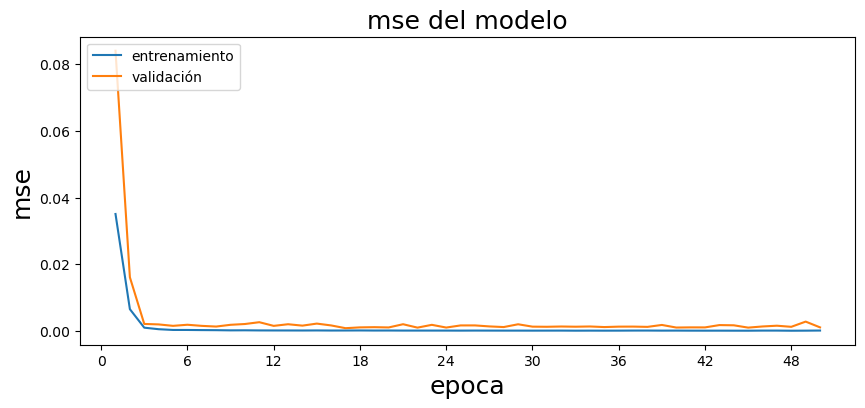


Epoch 1: val_mse did not improve from 0.00085

Epoch 1: val_mse did not improve from 0.00085

Epoch 1: val_mse did not improve from 0.00085

Epoch 1: val_mse did not improve from 0.00085

Epoch 1: val_mse improved from 0.00085 to 0.00076, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse did not improve from 0.00076

Epoch 1: val_mse

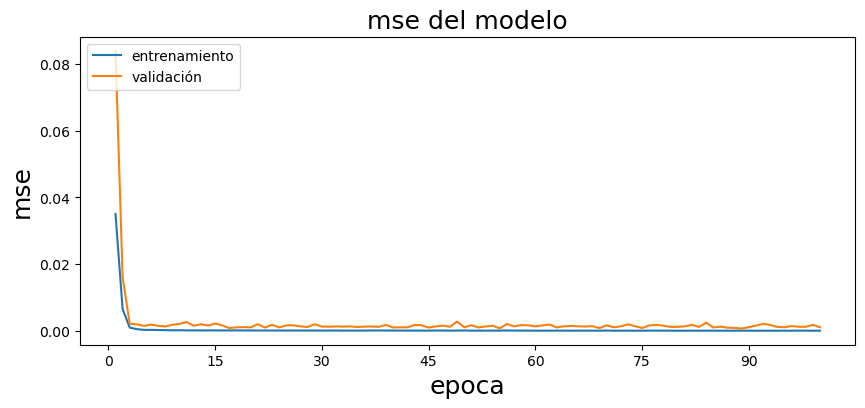


Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val

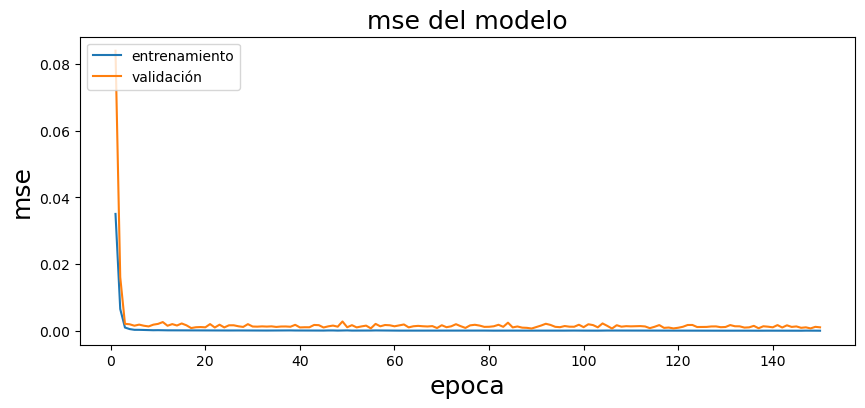


Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val

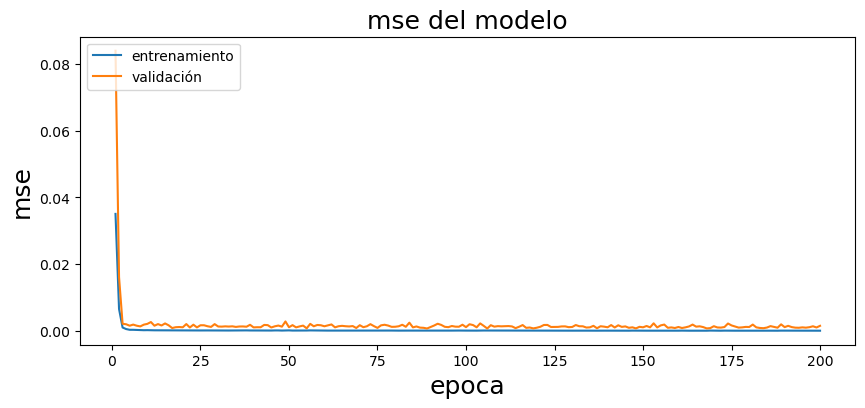


Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse did not improve from 0.00071

Epoch 1: val_mse improved from 0.00071 to 0.00063, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse did not improve from 0.00063

Epoch 1: val_mse

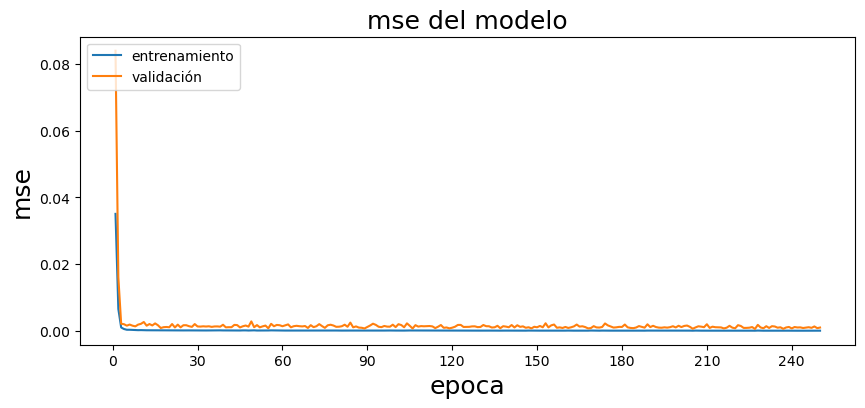


Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse did not improve from 0.00056

Epoch 1: val_mse improved from 0.00056 to 0.00055, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse

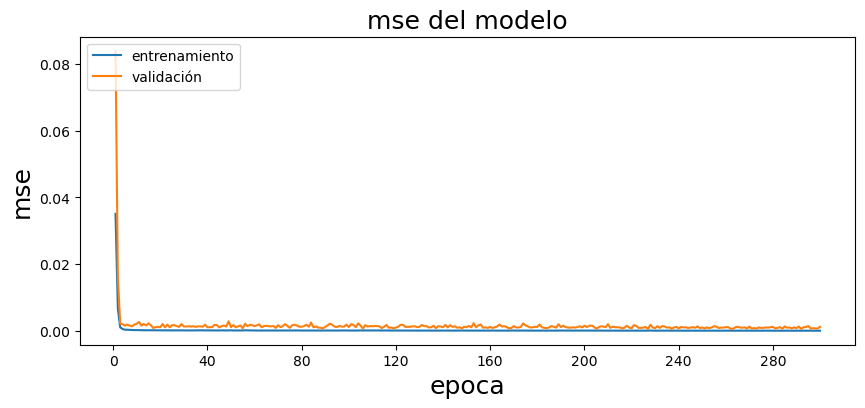


Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse did not improve from 0.00055

Epoch 1: val_mse improved from 0.00055 to 0.00049, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.00049

Epoch 1: val_mse did not improve from 0.00049

Epoch 1: val_mse did not improve from 0.00049

Epoch 1: val_mse did not improve from 0.00049

Epoch 1: val_mse did not improve from 0.00049

Epoch 1: val_mse

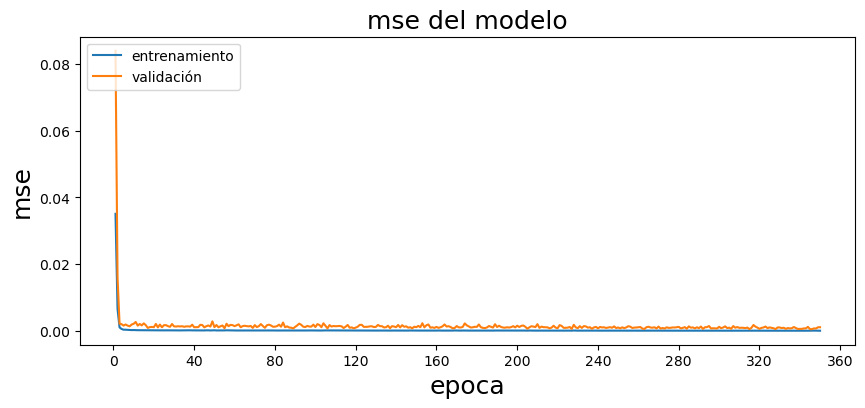

In [109]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

epochs = 500
batch_size = 56
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [110]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [111]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()

13/13 [==============================] - 0s 3ms/step


In [112]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

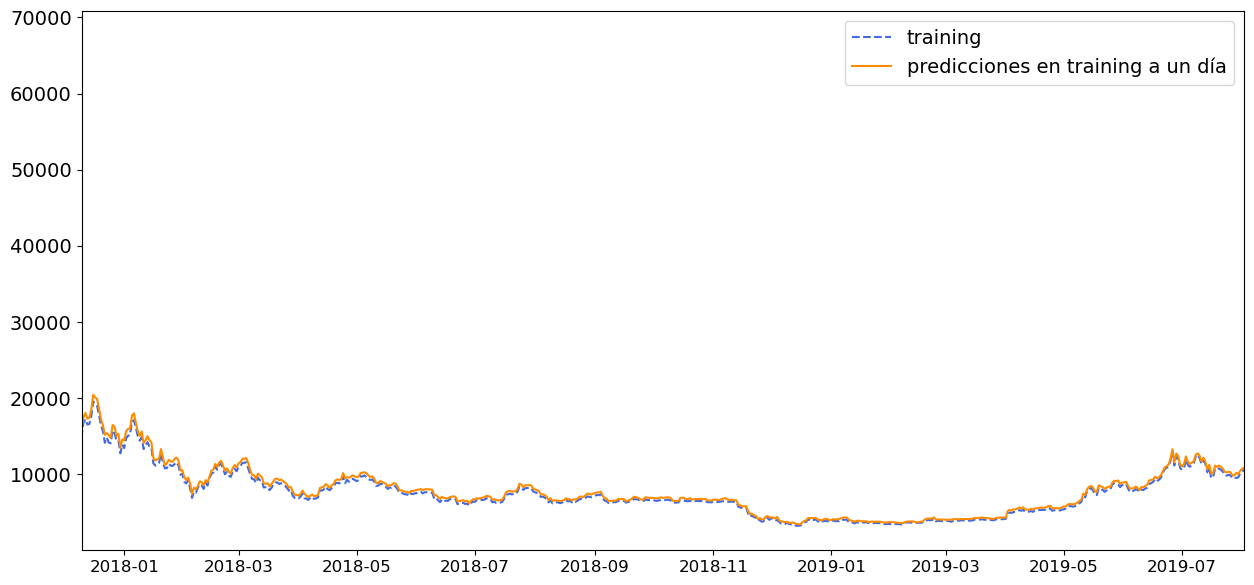

In [113]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[100],fechas_train[700]])
plt.legend(fontsize=14);

KeyError: -1

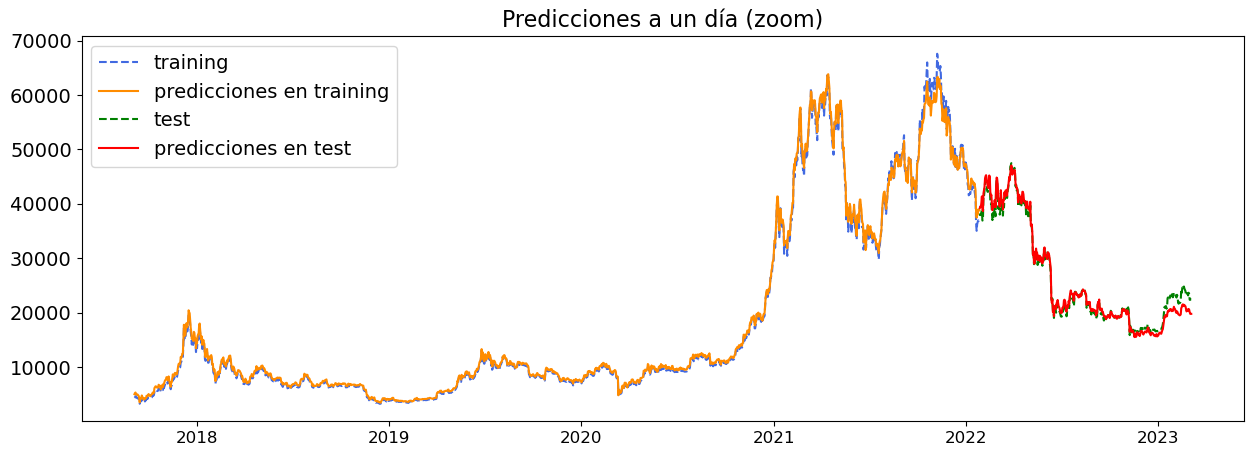

In [114]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[600],fechas_test[-1]]);

KeyError: 50

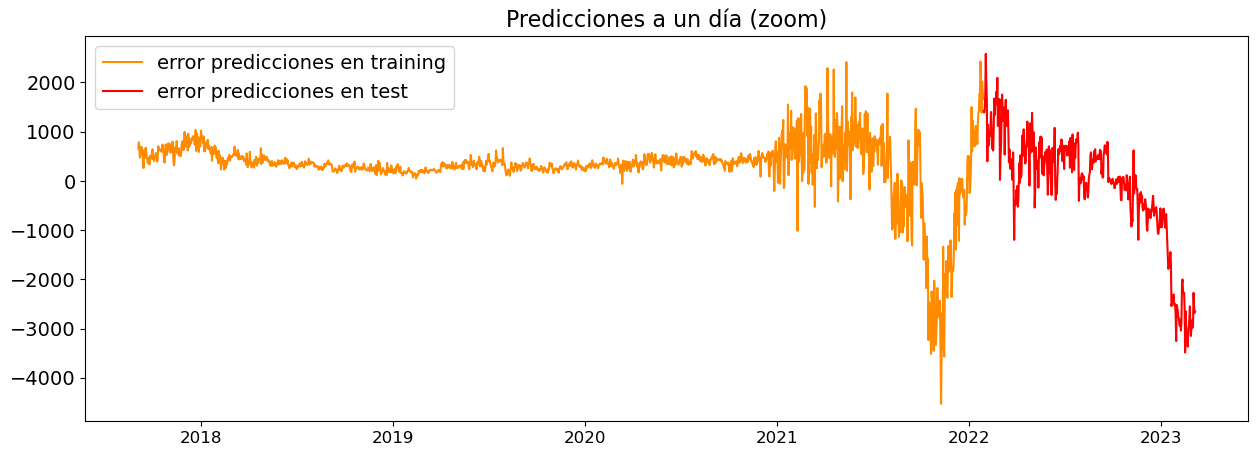

In [116]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train_pred - target_train,  c='darkorange',
         label='error predicciones en training')
plt.plot(fechas_test, target_test_pred - target_test,    c='red',
         label='error predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[600], fechas_test[50]]);

In [117]:
model.get_weights()

[array([[ 0.46814594,  0.22863589,  0.37312463, ...,  0.10842164,
         -0.10186171,  0.23280217],
        [-0.0025841 , -0.15857549,  0.07365607, ...,  0.02110565,
          0.13884157,  0.03997612],
        [ 0.3690007 , -0.11355685, -0.06136407, ..., -0.17358752,
         -0.05947658,  0.16534165],
        ...,
        [-0.24341671,  0.07310672, -0.2191829 , ..., -0.01362733,
         -0.01413303,  0.23333104],
        [-0.2859455 , -0.3110277 ,  0.21930414, ..., -0.42127255,
         -0.07037374,  0.1612258 ],
        [-0.01636678,  0.15865579, -0.19334807, ...,  0.17814457,
         -0.08433511, -0.02567076]], dtype=float32),
 array([[ 0.2763558 , -0.16622417,  0.30512655, ...,  0.313903  ,
          0.17188628,  0.088919  ],
        [ 0.36331648, -0.101262  ,  0.41403833, ..., -0.02122769,
          0.06605537,  0.05750897],
        [ 0.27479914, -0.1463955 ,  0.09253784, ...,  0.09610634,
          0.07092106,  0.1230717 ],
        ...,
        [ 0.11870705, -0.08121633,  0.1

In [118]:
# Modelos de referencia: modelo persistente (a 1 día, 7 días etc.)

# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.9983523624781478
R2 del modelo en test          :  0.9841441547375899
R2 modelo persistente 1 día    :  0.9895495488920019
R2 modelo persistente 1 semana :  0.9251637943889098
R2 modelo persistente 4 semanas:  0.6907733355180574
R2 modelo persistente 1 año:  -0.22122787026616741


In [119]:
# R2(y_real, y_predicho) = 1 - MSE/VAR(y real)
# r2(v1, v2) # correlación lineal

# r2(precio en euros, precio en céntimos de euros) = 1.
# ** R2(precio en euros, precio en céntimos de euros) = 1 - promedio((precio1-precio2)^2)/VAR(precio1) << -1

In [120]:
# RMSEs
#El resultado es la desviación estándar de los valores residuales (errores de predicción). de cuánto se ha equivocado del valor de vitocin al día. 
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  709.0867026694978
RMSE del modelo en test          :  1161.1065490667165
RMSE modelo persistente 1 día    :  941.976298601346
RMSE modelo persistente 1 semana :  2508.804207194316
RMSE modelo persistente 4 semanas:  4802.904446674778


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

In [122]:
def step_generativo(model, ventana, X, i):
    # ventana: va a tener dimensiones (1, lookback, n_variables)
    # El target está en (0,:,0)
    # La posición (0,0,0) es el target en el día más antiguo de la ventana
    # La posición (0,0,-1) es el target en el día más reciente de la ventana
    # Las variables calendario están en (0,:,1:)
    # Las variables calendario para el último día de la ventana están en (0,-1,1:)

    z = model.predict(ventana)[0,0] # predicción nueva
    target_pred = inverse_transform(z)
    ventana_nueva = None
    if i < (len(X)-1):
        ventana_nueva = np.zeros(ventana.shape)
        # muevo un día hacia atrás todas las variables de la ventana:
        ventana_nueva[0,:-1,:] = ventana[0,1:,:].copy()

        # introduzco las variables calendario para el último día de la ventana:
        ventana_nueva[0,-1,1:] = X[i+1,-1,1:]

        # meto la predicción como última obervación del target:
        ventana_nueva[0,-1,0] = z
        
        
    return target_pred, ventana_nueva

In [123]:
def generativo(model, X):
    ventana = np.array([X[0]]).copy()    
    salidas = []
    for i in range(len(X)):
        target_pred, ventana_nueva = step_generativo(model, ventana, X, i)
        salidas.append(target_pred)
        ventana = ventana_nueva
    
    return salidas

In [124]:
sal = generativo(model, X_test)

1/1 [==============================] - 0s 24ms/step


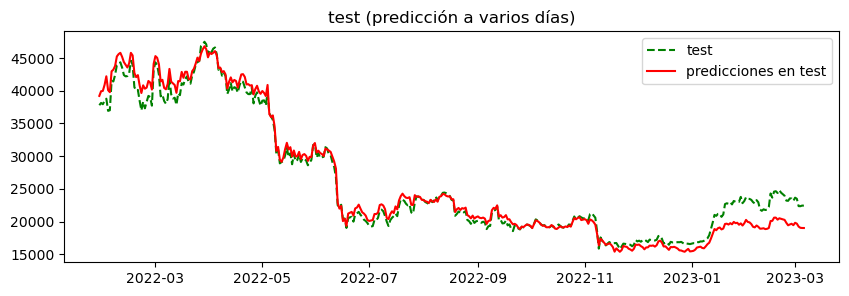

In [125]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();

In [126]:
len(target_test)

403

In [127]:
preds = pd.DataFrame({"fecha": fechas_test,
                      "Precio_bitcoin_estimado":sal,
                     "Precio_real": target_test})
preds

,fecha,Precio_bitcoin_estimado,Precio_real
1610,2022-01-28 00:00:00+00:00,39211.927596,37789.478820
1611,2022-01-29 00:00:00+00:00,39922.889712,38137.472697
1612,2022-01-30 00:00:00+00:00,39977.487986,37936.328777
1613,2022-01-31 00:00:00+00:00,40897.850257,38455.689663
1614,2022-02-01 00:00:00+00:00,42209.502173,38784.502299
...,...,...,...
2008,2023-03-02 00:00:00+00:00,19675.373027,23479.321887
2009,2023-03-03 00:00:00+00:00,19234.610118,22359.217210
2010,2023-03-04 00:00:00+00:00,19044.767193,22347.343924
2011,2023-03-05 00:00:00+00:00,19016.349982,22442.474539


In [129]:
preds.to_csv("predicciones_TFM.csv")

In [131]:
val = pd.DataFrame({"fechas_validación": fechas_train,
                      "Precio_bitcoin_estimado_Validación":target_train_pred,
                     "Precio_real": target_train})
val

,fechas_validación,Precio_bitcoin_estimado_Validación,Precio_real
3,2017-09-04 00:00:00+00:00,4999.675293,4340.747306
4,2017-09-05 00:00:00+00:00,5211.821777,4426.660415
5,2017-09-06 00:00:00+00:00,5306.146484,4610.806603
6,2017-09-07 00:00:00+00:00,5096.400879,4621.992816
7,2017-09-08 00:00:00+00:00,4897.166504,4341.488461
...,...,...,...
1605,2022-01-23 00:00:00+00:00,38340.585938,36254.879857
1606,2022-01-24 00:00:00+00:00,38043.074219,36656.193822
1607,2022-01-25 00:00:00+00:00,38965.597656,36946.238283
1608,2022-01-26 00:00:00+00:00,38719.625000,36851.369880


In [133]:
val.to_csv("Validacion_TFM.csv")

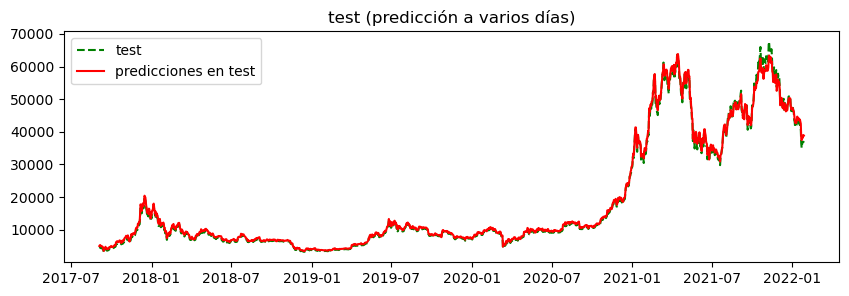

In [132]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_train, target_train, '--g', label='test')
plt.plot(fechas_train, target_train_pred, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();